# Titanic survivor prediction

Hi, in this notebook we are going to explore, analyze and predict whether a passenger on the Titanic survived or not. First, we should start by downloading the data.

![alttext](https://media.giphy.com/media/4d8uCMJE5b8ru/giphy.gif)

## Download the data

You can find the dataset [here](https://www.kaggle.com/c/titanic/data).

Now let's import the first necessary libraries.

## Importing the libaries

In [0]:
import math,time,datetime

import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import string
# Classifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,preprocessing,metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
# Warnings
import warnings
warnings.filterwarnings('ignore')

## Importing the data
Now let's import the dataset via pandas

In [81]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Data desrciption

**Survival**: 0 = No, 1 = Yes

**pclass (Ticket class)**: 1 = 1st, 2 = 2nd, 3 = 3rd

**sex**: Sex

**Age**: Age in years

**sibsp**: number of siblings/spouses aboard the Titanic

**parch**: number of parents/children aboard the Titanic

**ticket**: Ticket number

**fare**: Passenger fare

**cabin**: Cabin number

**embarked**: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

Columns as described as shown above.

In [83]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Outlier Detection and Removal

To improve the classification accuracy we are now going to find Outliers in the dataset and remove them.

In [0]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [0]:
outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

## Missing values

Now let's find out how many missing values we have and in which feature they are.

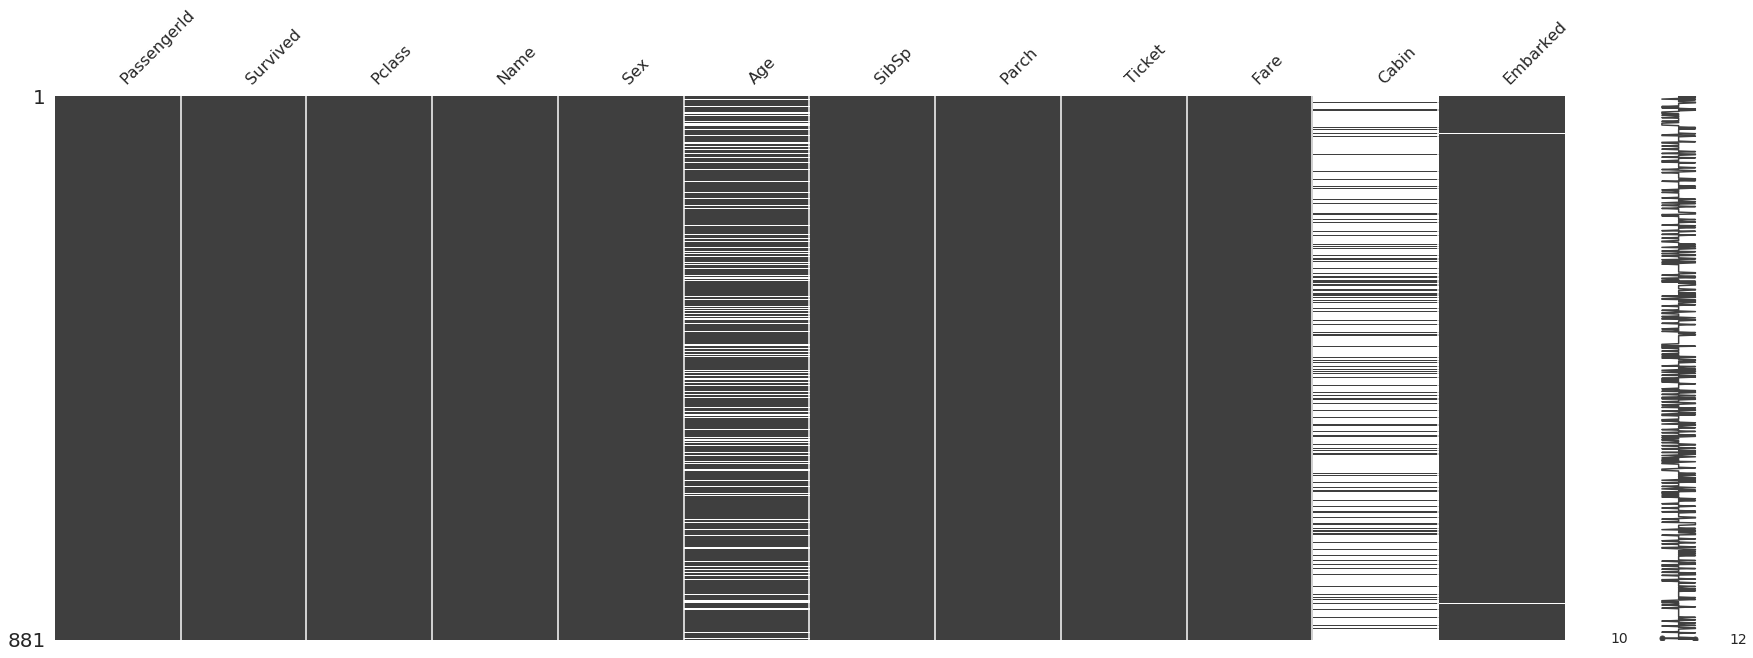

In [86]:
missingno.matrix(train,figsize=(30,10))

From this chart we can see that **Age** has(I would argue) about 15% missing values. **Cabin** has a lot more values missing let's say about 80%. **Embarked** has just a few missing, I would argue under 1%.

Now let's see how many missing values are there exactly.

In [87]:
df_length = len(train)
print("Train total length: " +  str(df_length))
for i in train.columns:
    df_nans = df_length - train[i].value_counts().sum()
    print(i + ": " + str(df_nans) + "   " + str(round((df_nans/df_length)*100)) + "% missing")

Train total length: 881
PassengerId: 0   0.0% missing
Survived: 0   0.0% missing
Pclass: 0   0.0% missing
Name: 0   0.0% missing
Sex: 0   0.0% missing
Age: 170   19.0% missing
SibSp: 0   0.0% missing
Parch: 0   0.0% missing
Ticket: 0   0.0% missing
Fare: 0   0.0% missing
Cabin: 680   77.0% missing
Embarked: 2   0.0% missing


In [88]:
df_length = len(test)
print("Train total length: " +  str(df_length))
for i in test.columns:
    df_nans = df_length - test[i].value_counts().sum()
    print(i + ": " + str(df_nans) + "   " + str(round((df_nans/df_length)*100)) + "% missing")

Train total length: 418
PassengerId: 0   0.0% missing
Pclass: 0   0.0% missing
Name: 0   0.0% missing
Sex: 0   0.0% missing
Age: 86   21.0% missing
SibSp: 0   0.0% missing
Parch: 0   0.0% missing
Ticket: 0   0.0% missing
Fare: 1   0.0% missing
Cabin: 327   78.0% missing
Embarked: 0   0.0% missing


### Handling the missing data

#### Age

Now let's focus on how to solve the problem with the missing data in the feature **age**. As I showed earlier we have 177 times missing ages in the dataset. Which is almost a quarter! So we need to find a way to replace them. After brainstorming about this problem I came up with the following plan:

- 1. If the persons' sex is male and he has the word **Master** in his name we set the age to the average value of males under 21.
- 2. If the persons' sex is male and he has the word **Mr** in his name and travels alone his age is set to the average age of males with **Mr** in his name who travel alone. Else: The age is set to the average age of males with the word **Mr** in his name.
- 3. If the persons' sex is female and has **Miss** in her name her age is set to the average age of females under 21.
- 4. If the persons' sex is female and has **Mrs** in her name and travels alone her age is set to the average age of females who travel alone and have **Mrs** in her name. Else: The age is set to the average age of females with the word **Mrs** in her name.

Alright now let's develop a method which replaces the NaN's with the age set by the rules before.

But first we need to fill the missing values(currently NaN) with 0's to replace them.


In [89]:
train.Age.fillna(0,inplace=True)
test.Age.fillna(0,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [90]:
sum_male_under_21 = 0
sum_male_under_21_c = 0
sum_male_alone = 0
sum_male_alone_c = 0
sum_male_over_21 = 0
sum_male_over_21_c = 0

sum_female_under_21 = 0
sum_female_under_21_c = 0
sum_female_alone = 0
sum_female_alone_c = 0
sum_female_over_21 = 0
sum_female_over_21_c = 0


for i, row in train.iterrows():
    if train['Age'][i] != 0: 
        #male
        if train['Age'][i] < 21: 
            if train['Sex'][i] == 'male':
                sum_male_under_21 = sum_male_under_21 + train['Age'][i]
                sum_male_under_21_c = sum_male_under_21_c + 1
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'male':
                sum_male_over_21 = sum_male_over_21 + train['Age'][i]
                sum_male_over_21_c = sum_male_over_21_c + 1    
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'male':
                if train['SibSp'][i] == 0:
                    if train['Parch'][i] == 0:
                        sum_male_over_21 = sum_male_alone + train['Age'][i]
                        sum_male_over_21_c = sum_male_alone_c + 1
        #female
        if train['Age'][i] < 21: 
            if train['Sex'][i] == 'female':
                sum_female_under_21 = sum_female_under_21 + train['Age'][i]
                sum_female_under_21_c = sum_female_under_21_c + 1
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'female':
                sum_female_over_21 = sum_female_over_21 + train['Age'][i]
                sum_female_over_21_c = sum_female_over_21_c + 1    
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'female':
                if train['SibSp'][i] == 0:
                    if train['Parch'][i] == 0:
                        sum_female_over_21 = sum_female_alone + train['Age'][i]
                        sum_female_over_21_c = sum_female_alone_c + 1
                        
                        
avg_male_under_21 = sum_male_under_21 / sum_male_under_21_c
avg_male_over_21 = sum_male_over_21 / sum_male_over_21_c
avg_male_alone = 0
avg_female_under_21 = sum_female_under_21 / sum_female_under_21_c
avg_female_over_21 = sum_female_over_21 / sum_female_over_21_c
avg_female_alone = 0

print(avg_male_under_21,avg_male_over_21,avg_male_alone,avg_female_under_21,avg_female_over_21,avg_female_alone,sep='\n')

13.246764705882354
32.0
0
11.883116883116884
30.5
0


Now let's fill in the matching **ages**:

In [0]:
c = 0
while c < 2:
    if (c == 0):
        f = train
    if (c == 1):
        f = test
    for i, row in f.iterrows():
        if f['Age'][i] == 0: 
            #male
            if f['Age'][i] < 21: 
                if f['Sex'][i] == 'male':
                    f.loc[i,'Age'] = avg_male_under_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'male':
                    f.loc[i,'Age'] = avg_male_over_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'male':
                    if f['SibSp'][i] == 0:
                        if f['Parch'][i] == 0:
                            f.loc[i,'Age'] = avg_male_alone
            #female
            if f['Age'][i] < 21: 
                if f['Sex'][i] == 'female':
                    f.loc[i,'Age'] = avg_female_under_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'female':
                    f.loc[i,'Age'] = avg_female_over_21 
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'female':
                    if f['SibSp'][i] == 0:
                        if f['Parch'][i] == 0:
                            f.loc[i,'Age'] = avg_female_alone
    c = c + 1                        

In [92]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
876,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.00,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.00,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,11.883117,1,2,W./C. 6607,23.45,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.00,C148,C
880,891,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,370376,7.75,NaN,Q


In [94]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,13.246765,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,13.246765,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,13.246765,1,1,2668,22.3583,NaN,C


#### Embarked

For the **Embarked** feature we know that there are only **2** rows where it is missing, so let's just drop them to fix that.

In [98]:
train.drop(index=[61,829],inplace=True)
train.loc[train['Embarked'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


## Analyse data

Before we start analyzing each feature on its own, we should start by finding out the data type of each feature:

In [99]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We see that there are just a few features who aren't in the data type of a numerical value e.g. int or float. This is going to be a good thing for the feature encoding later on(Same goes for the test dataframe).

Now let's start analyzing the data, first let's start with

### Survived

0 = passenger not survived
1 = passenger survived

This is the variable we want our machine learning model to predict based off all the others.

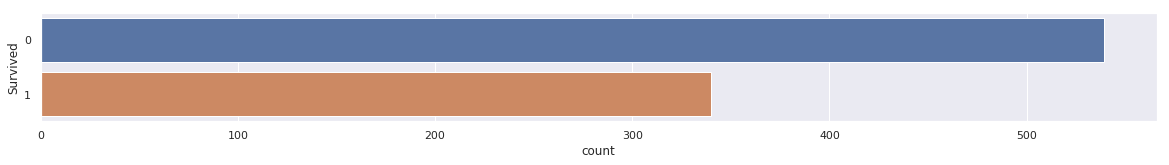

In [100]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y='Survived',data=train)

In [101]:
len(train.loc[train['Survived'] == 1])

340

In [102]:
len(train.loc[train['Survived'] == 0])

539

Therefore we can see that more than 500 people died on the Titanic and about 350 people survived the sinking.
So the probability that a randomly picked passenger survived the sinking is 340/889 so about **38%**.

### Pclass

Description: The ticket class of the passenger.
Key: 1=1st 2=2nd 3=3rd

We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.
For example, if there are values which are completely outside of the distribution, we may not want to include them in our model. So let's check that out.

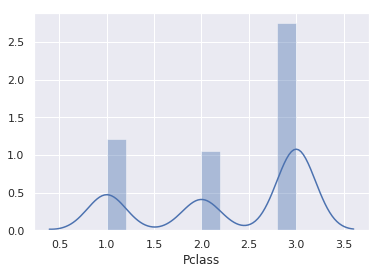

In [104]:
sns.distplot(train.Pclass)

We see that this is not really the case so we'll use this feature for our prediction later on.

### Sex

Let's compare the distribution of the genders.

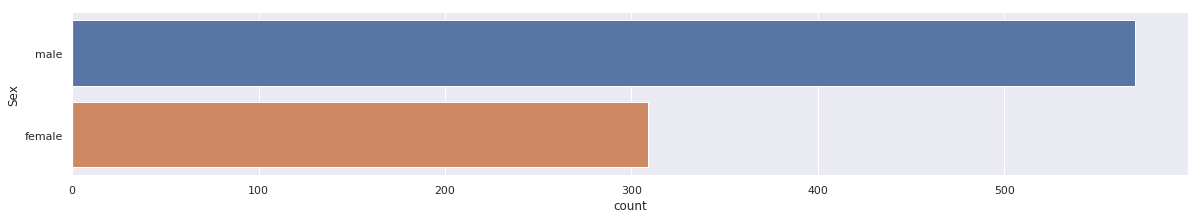

In [105]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y='Sex',data=train)

Now let's check out how many of the male's and female's have survived. 

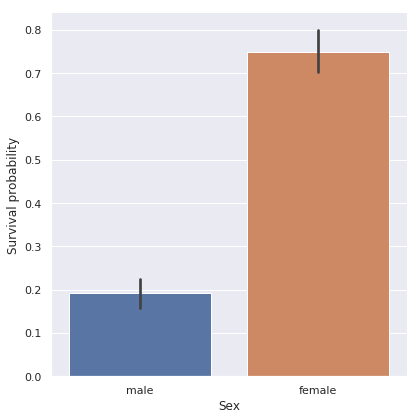

In [106]:
g = sns.catplot(x='Sex',y='Survived',data=train,height=6,kind='bar') 
g.set_ylabels('Survival probability')

So as we see the probability that a randomly picked passenger survived the Titanic is 4-times higher if the passenger is female.

### Age 

Now let's check how the different ages are spread in the dataset.

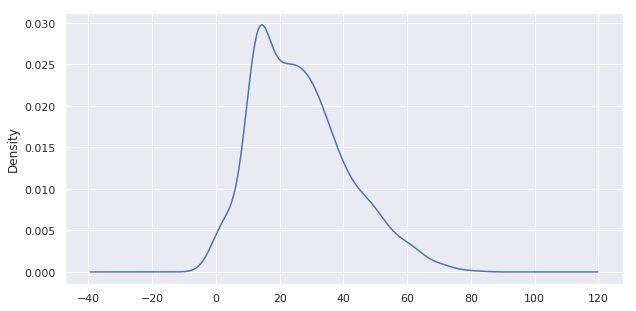

In [107]:
plt.figure(figsize=(10,5))
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age.plot(kind='kde')    

In [108]:
train['Age'].sum() / len(train)

26.467225078675586

Therefore we know that the average age aboard the Titanic is about **26 years**.

Now let's find out how the probability to survive the sinking is with view on the different ages.

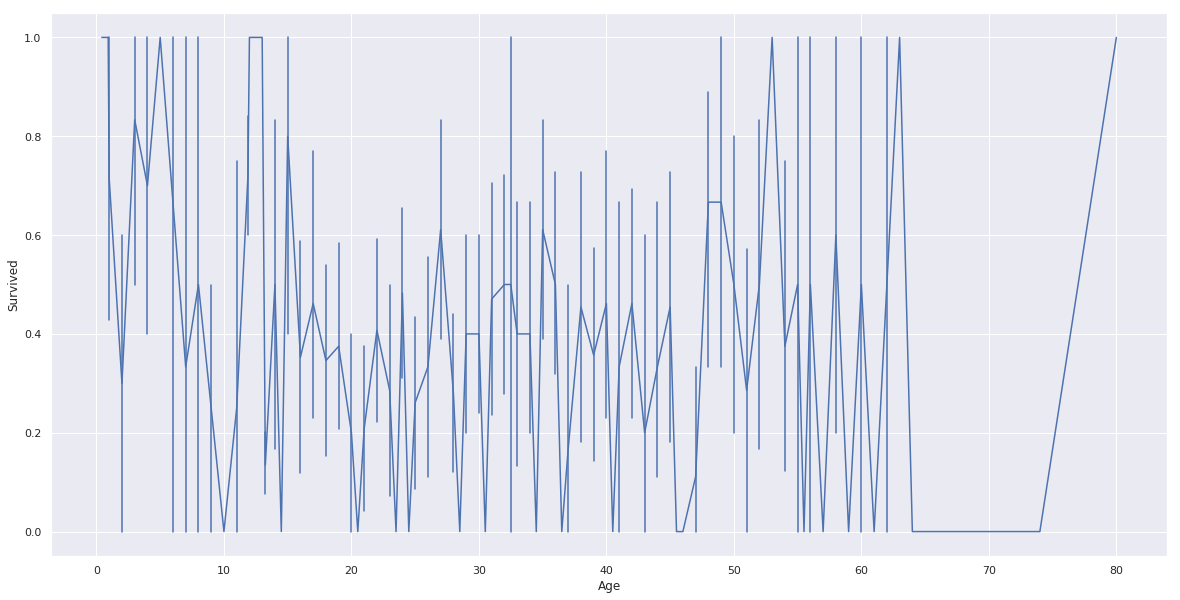

In [109]:
fig = plt.figure(figsize=(20,10))
sns.set(style='darkgrid')
sns.lineplot(x='Age',y='Survived',data=train,err_style="bars")

Out of this we can see that if a passenger is between 65 and 74 he's going to die during the sinking, this is the worst age of all! For the rest take a look at the chart yourself :)

### SibSp

Now let's check how many sibilings/spouses are aboard with the passenger.

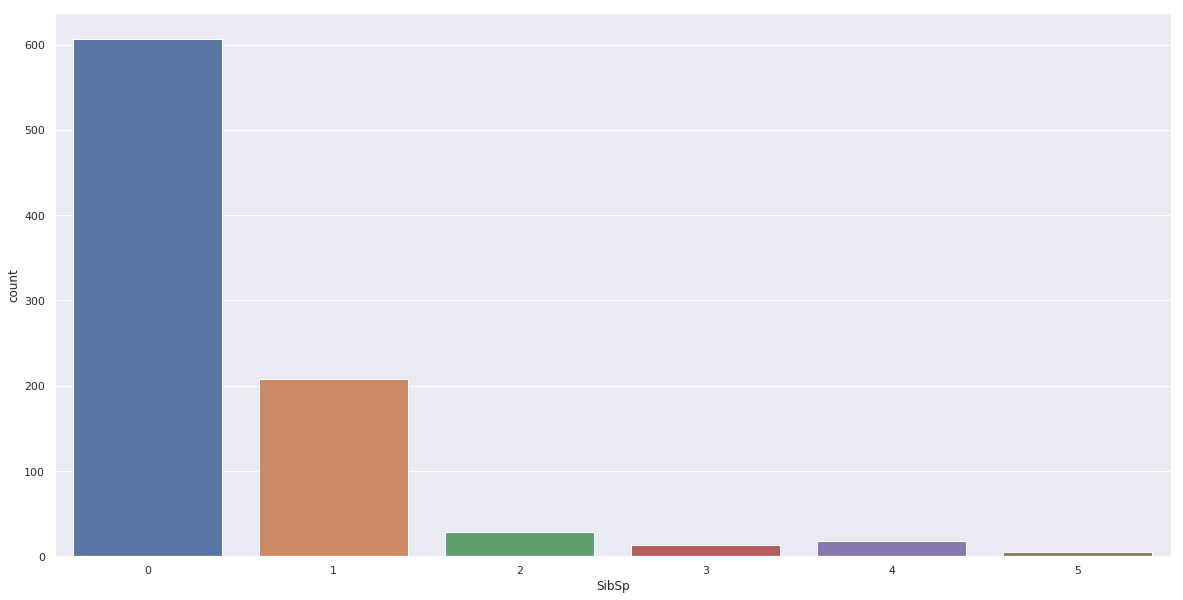

In [110]:
fig = plt.figure(figsize=(20,10))
g = sns.countplot(x='SibSp',data=train)

Therefore we can see that most passengers traveled alone.

### Parch

Now let's do the same as we did with the sibilings/spouses with parents/children aboard the Titanic.

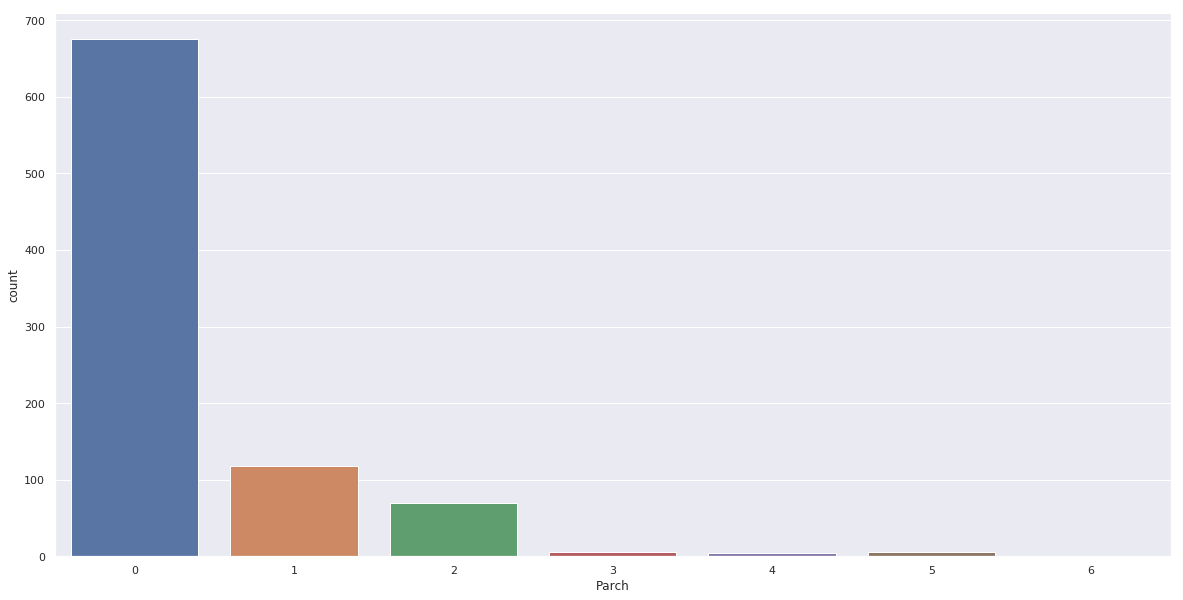

In [111]:
fig = plt.figure(figsize=(20,10))
g = sns.countplot(x='Parch',data=train)

### Ticket

As you've might observed earlier there are a **lot** of different ticket types:

In [112]:
train.Ticket.value_counts()

347082                7
1601                  7
3101295               6
CA 2144               6
347088                6
S.O.C. 14879          5
382652                5
347077                4
349909                4
2666                  4
113760                4
LINE                  4
PC 17757              4
113781                4
W./C. 6608            4
4133                  4
17421                 4
PC 17572              3
C.A. 34651            3
110152                3
PC 17760              3
F.C.C. 13529          3
239853                3
13502                 3
110413                3
347742                3
345773                3
35273                 3
363291                3
PC 17755              3
                     ..
A/5 3902              1
112052                1
312993                1
STON/O2. 3101271      1
374887                1
113501                1
315084                1
370377                1
2685                  1
229236                1
SOTON/O.Q. 31013

So there are **680** unique ticket types. Wow! That is a lot, and really not easy to simplify in the feature encoding, later on, so we won't use this feature in it's natural form in the prediction later on.

### Fare

Description: How much the ticket cost for every individual passenger.

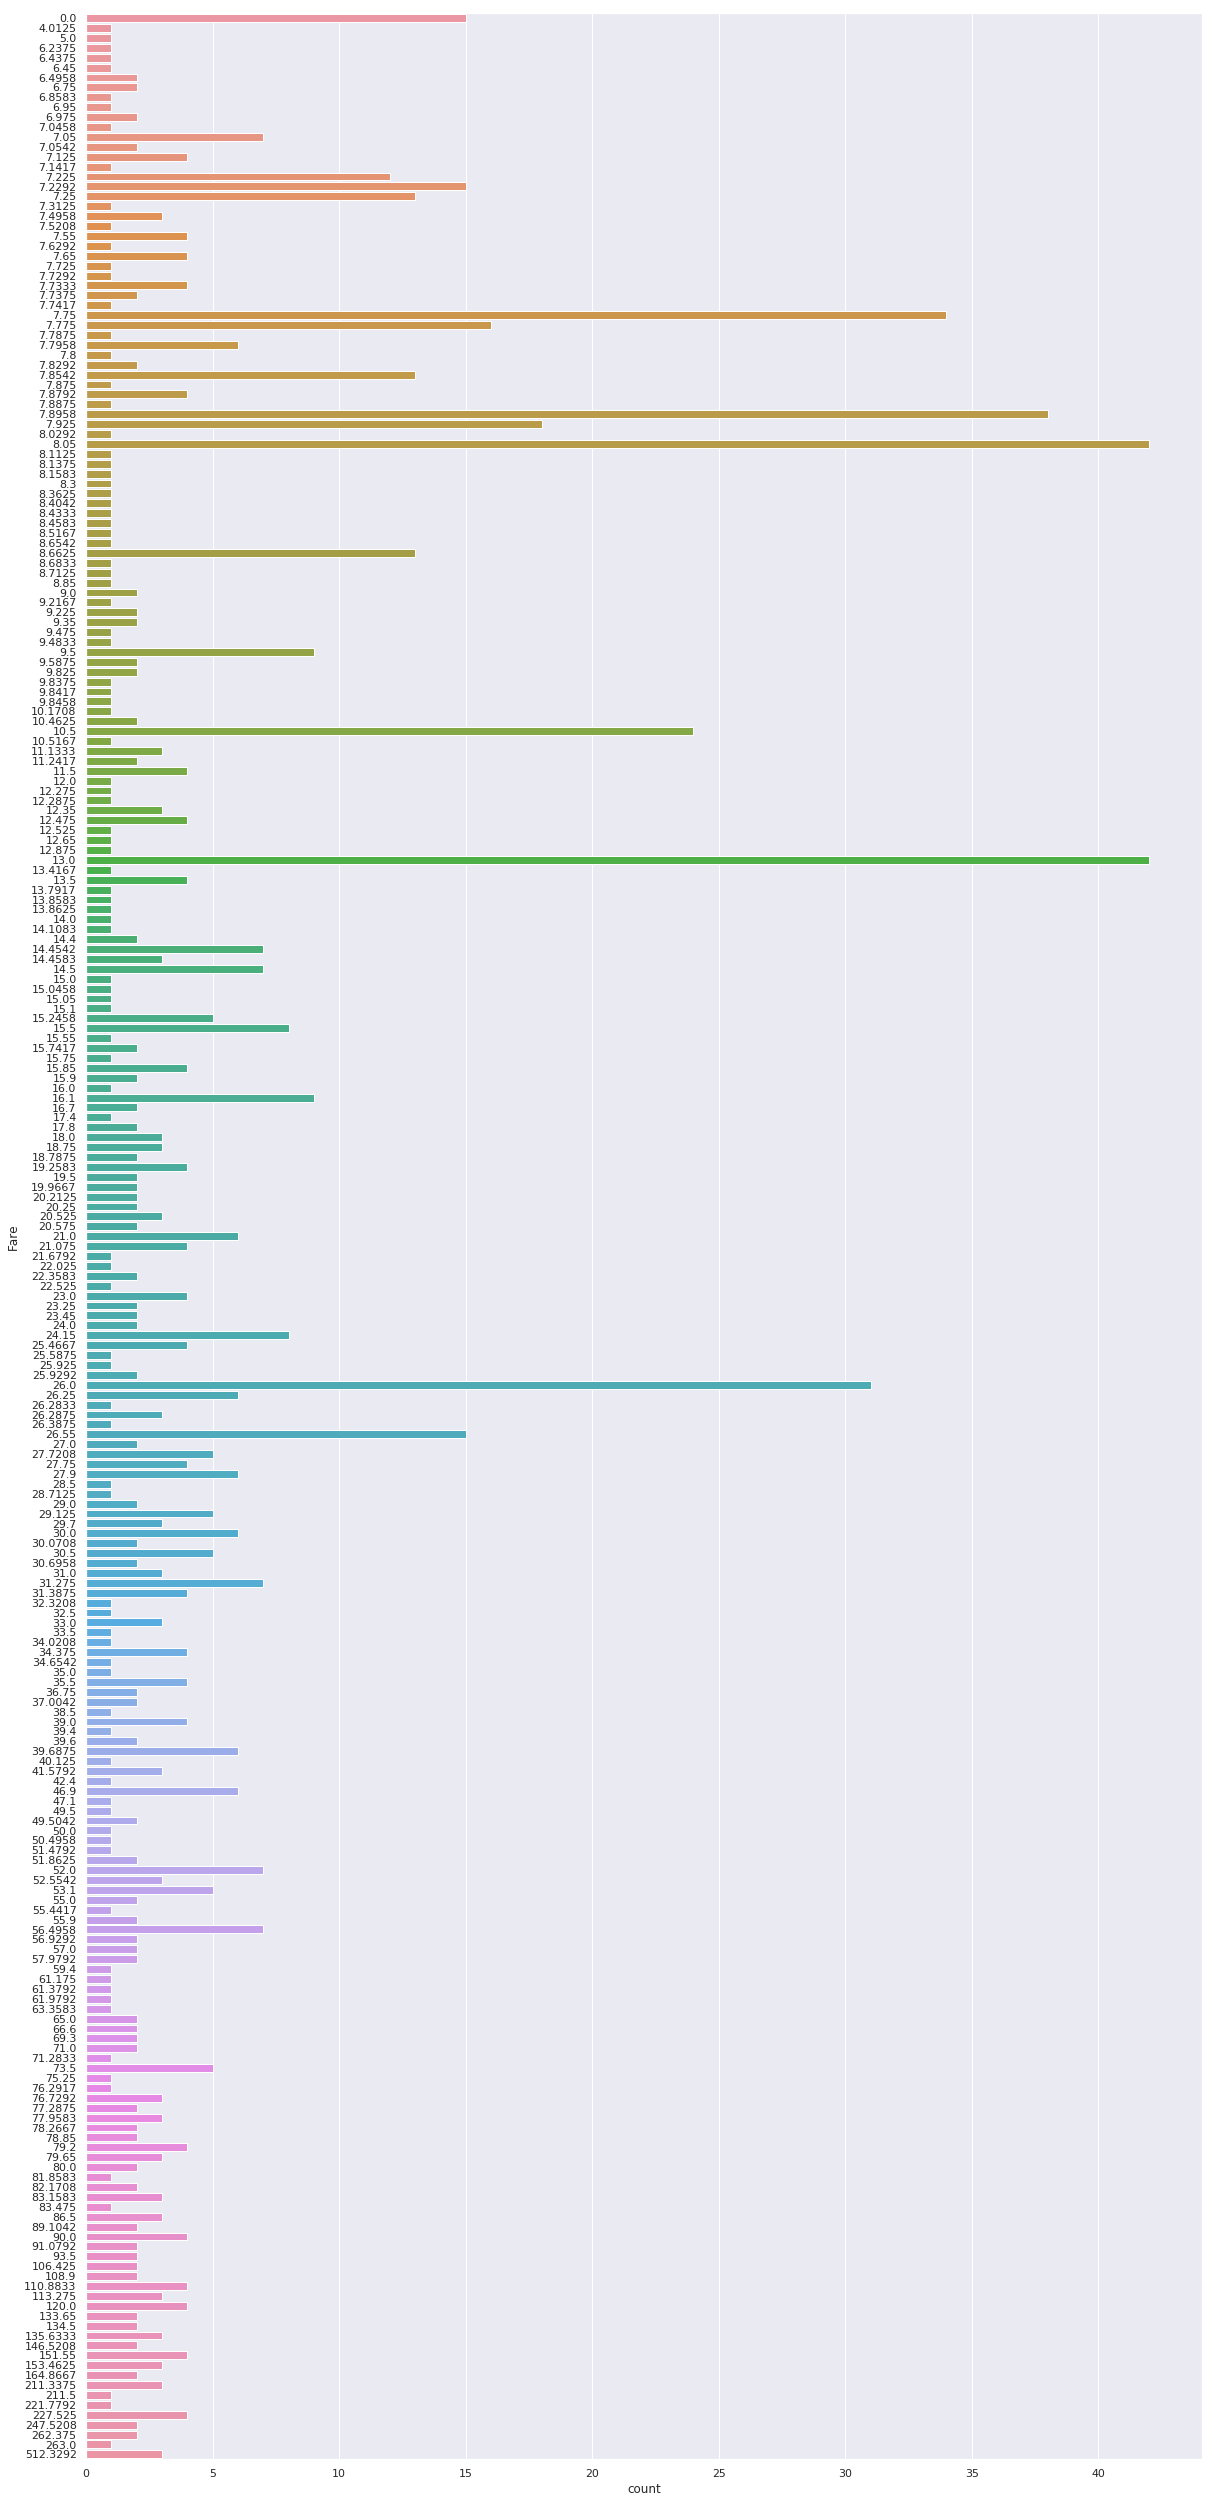

In [113]:
fig = plt.figure(figsize=(20,45))
sns.countplot(y='Fare',data=train)

Fun fact: This is the average ticket price for a fare on the Titanic.

In [114]:
train.Fare.sum() / len(train)

31.088252901023893

### Embarked

Description: Port's were the passengers had go on board of the Titanic.

Possible port's are: C = Cherbourg, Q = Queenstown, S = Southampton 

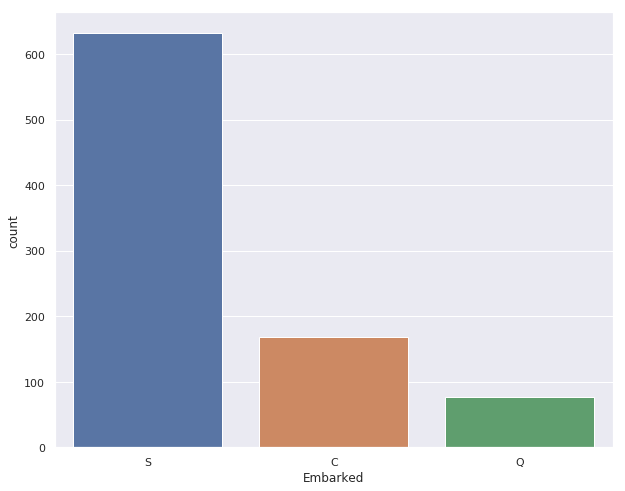

In [115]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x='Embarked',data=train)

## Feature Engineering

I'm going to engineer a couple of new features to improve the accuracy. For all catigorical features I'm going to add dummy data via pandas to create new columns(again for better accuracy).

In [118]:
df_all = train.append(test, ignore_index=True)
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Age and Fare in test data

In [119]:
df_all[ 'Age' ] = df_all.Age.fillna( df_all.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
df_all[ 'Fare' ] = df_all.Fare.fillna( df_all.Fare.mean() )

df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Family Size

In [120]:
family = pd.DataFrame()

family['FamilySize'] = df_all['SibSp'] + df_all.Parch + 1

family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


### Title

In [121]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = df_all[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


### Cabin

In [122]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = df_all.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


### Ticket

In [123]:
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = df_all[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Embarked

In [124]:
embarked = pd.get_dummies( df_all.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


### Pclass

In [125]:
pclass = pd.get_dummies( df_all.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


### Sex

In [126]:
sex = pd.get_dummies(df_all.Sex,prefix='Sex')
sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


### IsAlone

In [127]:
is_alone_l = []
for i,row in df_all.iterrows():
  if row.Parch == 0 and row.SibSp == 0:
    is_alone_l.append(1)
  else:
    is_alone_l.append(0)

is_alone = pd.DataFrame({'IsAlone':is_alone_l})
is_alone.head()

,IsAlone
0,0
1,0
2,1
3,0
4,1


### All together

In [128]:
full_X = pd.concat([sex,df_all.Fare,family,is_alone,title,cabin,ticket,embarked,pclass],axis=1)
full_X.head()

,Sex_female,Sex_male,Fare,FamilySize,Family_Single,Family_Small,Family_Large,IsAlone,Master,Miss,...,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,7.2500,2,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,71.2833,2,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,7.9250,1,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,53.1000,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,0,1,8.0500,1,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1


In [129]:
train_X = full_X[ 0:len(train) ]
train_y = train.Survived
test_X = full_X[ len(train): ]

print (full_X.shape , train_X.shape , train_y.shape, test_X.shape)

(1297, 66) (879, 66) (879,) (418, 66)


Now I'm going to create a new DataFrame to compare the model results later on with the original results. 

P.S: I got the original data from [here](https://www.kaggle.com/tarunpaparaju/how-top-lb-got-their-score-use-titanic-to-learn)

In [0]:
submission_df = pd.DataFrame({'PassengerId':[],'Survived':[]},dtype=int)

In [0]:
submission_df['PassengerId'] = test['PassengerId']

In [132]:
submission_df.head()

,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN


## Building model

Now we are good to go to build our first model. However, before we can start let's separate the data.

### Define a function to fit ML algorithms
Since we will use a lot of different algorithms for the sklearn libary, they all take similiar input and give the same output. So to prevent writing code multiple times let's just define a function who does that for us:

In [0]:
solution_data = pd.read_csv('/content/test_data.csv')
solution = pd.DataFrame()
solution['PassengerId'] = solution_data['PassengerId']
solution['Survived'] = solution_data['Survived']

In [0]:
def predict_on_truth(model):
  liste = model.predict(test_X)
  submission_df['Survived'] = liste
  right_count = 0
  index = 0
  for i in submission_df['Survived']:
    if i == solution.iat[index,1]:
      right_count = right_count + 1
    index = index + 1  
    
  return(right_count / len(solution))    

In [0]:
test_size = 0.6
seed = 7
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(train_X,train_y,test_size=test_size,random_state=seed)

In [0]:
#Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo):
    
    cv = 10
    # One Pass
    model = algo.fit(features_train,labels_train)
    acc = predict_on_truth(model)
    
    # Cross Validation 
    test_pred = model_selection.cross_val_predict(algo, 
                                                  features_test, 
                                                  labels_test, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(labels_test, test_pred) * 100, 2)
    
    return acc,acc_cv,model

### Logistic Regression

In [137]:
start_time = time.time()
acc_log,acc_log_cv,model = fit_ml_algo(LogisticRegression())
log_time = (time.time() - start_time)
log_model = model
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_log_cv)
print("Running time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 0.784688995215311
Accuracy CV 10-Fold: 82.2
Running time: 0:00:00.130795


### K-Nearest Neighbours

In [138]:
start_time = time.time()
acc_knn,acc_knn_cv,model = fit_ml_algo(KNeighborsClassifier())
knn_model = model
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_knn_cv)
print("Running time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 0.6985645933014354
Accuracy CV 10-Fold: 80.49
Running time: 0:00:00.099455


### Gaussian Naive Bayes

In [139]:
start_time = time.time()
acc_gaussian,acc_gaussian_cv,model = fit_ml_algo(GaussianNB())
gaussian_model = model
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_gaussian_cv)
print("Running time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 0.423444976076555
Accuracy CV 10-Fold: 58.33
Running time: 0:00:00.063851


### Linear Support Vector Machines(Linear SVC)

In [140]:
start_time = time.time()
acc_linear_svc,acc_linear_svc_cv,model = fit_ml_algo(LinearSVC())
acc_linear_svc_model = model
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_linear_svc_cv)
print("Running time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 0.7488038277511961
Accuracy CV 10-Fold: 81.25
Running time: 0:00:00.378024


### Decision Tree

In [141]:
start_time = time.time()
acc_tree,acc_tree_cv,model = fit_ml_algo(DecisionTreeClassifier())
tree_model = model
tree_time = (time.time() - start_time)
print("Accuracy: %s" % acc_tree)
print("Accuracy CV 10-Fold: %s" % acc_tree_cv)
print("Running time: %s" % datetime.timedelta(seconds=tree_time))

Accuracy: 0.7655502392344498
Accuracy CV 10-Fold: 81.44
Running time: 0:00:00.079019


### Random Forest

In [142]:
start_time = time.time()
acc_forest,acc_forest_cv,model = fit_ml_algo(RandomForestClassifier())
forest_model = model
forest_time = (time.time() - start_time)
print("Accuracy: %s" % acc_forest)
print("Accuracy CV 10-Fold: %s" % acc_forest_cv)
print("Running time: %s" % datetime.timedelta(seconds=forest_time))

Accuracy: 0.7727272727272727
Accuracy CV 10-Fold: 79.92
Running time: 0:00:00.172041


### Gradient Boosting Classifier

In [143]:
start_time = time.time()
acc_boost,acc_boost_cv,model = fit_ml_algo(GradientBoostingClassifier())
boost_model = model
boost_time = (time.time() - start_time)
print("Accuracy: %s" % acc_boost)
print("Accuracy CV 10-Fold: %s" % acc_boost_cv)
print("Running time: %s" % datetime.timedelta(seconds=boost_time))

Accuracy: 0.7559808612440191
Accuracy CV 10-Fold: 82.39
Running time: 0:00:00.839038


### XG Boost

In [144]:
start_time = time.time()
acc_xg,acc_xg_cv,model = fit_ml_algo(xgb.XGBClassifier())
xg_model = model
xg_time = (time.time() - start_time)
print("Accuracy: %s" % acc_xg)
print("Accuracy CV 10-Fold: %s" % acc_xg_cv)
print("Running time: %s" % datetime.timedelta(seconds=xg_time))

Accuracy: 0.7583732057416268
Accuracy CV 10-Fold: 82.58
Running time: 0:00:01.043047


## Model Results

Which model had the bets cross-validation accuracy?

**Note**: This is our prediction results divided by the **original** data, so this is the score we care most about.

### Regular accuracy scores(original data)

In [145]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree','Random Forest','Gradient Boosting Classifier','XG Boost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian,  
        acc_linear_svc, 
        acc_tree,
        acc_forest,
        acc_boost,
        acc_xg,
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
1,Logistic Regression,0.784689
5,Random Forest,0.772727
4,Decision Tree,0.765550
7,XG Boost,0.758373
6,Gradient Boosting Classifier,0.755981
3,Linear SVC,0.748804
0,KNN,0.698565
2,Naive Bayes,0.423445


### Cross validation scores

In [146]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree','Random Forest','Gradient Boosting Classifier','XG Boost'],
    'Score': [
        acc_knn_cv,
        acc_log_cv,
        acc_gaussian_cv,
        acc_linear_svc_cv,
        acc_tree_cv,
        acc_forest_cv,
        acc_boost_cv,
        acc_xg_cv,
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,XG Boost,82.58
6,Gradient Boosting Classifier,82.39
1,Logistic Regression,82.20
4,Decision Tree,81.44
3,Linear SVC,81.25
0,KNN,80.49
5,Random Forest,79.92
2,Naive Bayes,58.33


## Submission

Now we are ready to do our kaggle submission, for that we just create a new dataframe with the **PassengerID** and **Survived/not Survived**.

In [147]:
liste = log_model.predict(test_X)

submission_df['Survived'] = liste
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [149]:
submission_df.to_csv('submission.csv',index=False)
print('Submission ready!')

Submission ready!


In [152]:
submissions_check = pd.read_csv("submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [151]:
right_count = 0
index = 0
for i in submission_df['Survived']:
  if i == solution.iat[index,1]:
    right_count = right_count + 1
  index = index + 1  
    
print(right_count / len(solution))    

0.784688995215311


## Conclusion

As we can see from the score above, we are going to score in this competition about 78%. In fact, our real score is 78.9% accuracy which brings us in the **top 28%**. Pretty good! :)